In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
import spacy
from tqdm.auto import tqdm
import re
import string

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
import html
import unicodedata

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
test = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip")

In [5]:
train["comment_text"][16]

"Bye! \n\nDon't look, come or think of comming back! Tosser."

In [23]:
train['comment_text'][5]

'congratulation well use tool well · talk'

In [6]:
test["comment_text"][1]

'== From RfC == \n\n The title is fine as it is, IMO.'

In [7]:
for sentence in train["comment_text"][:20]:
    print(len(sentence))

264
112
233
622
67
65
44
115
472
70
2875
56
319
819
219
610
57
48
118
440


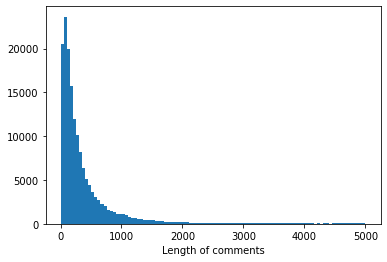

In [8]:
sentence_lengths = [len(sentence) for sentence in train["comment_text"]]
plt.hist(sentence_lengths,100)
plt.xlabel('Length of comments')
plt.show()

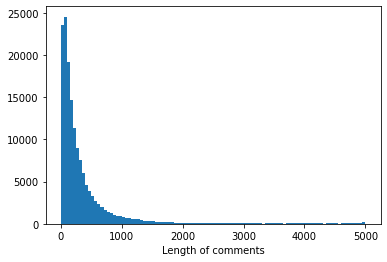

In [9]:
sentence_lengths = [len(sentence) for sentence in test["comment_text"]]
plt.hist(sentence_lengths,100)
plt.xlabel('Length of comments')
plt.show()

In [10]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [11]:
feature = train.drop(['id', 'comment_text'], axis=1)
counts = []                                               
categories = list(feature.columns.values)
categories

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Text(0.5, 0, 'Feature Labels')

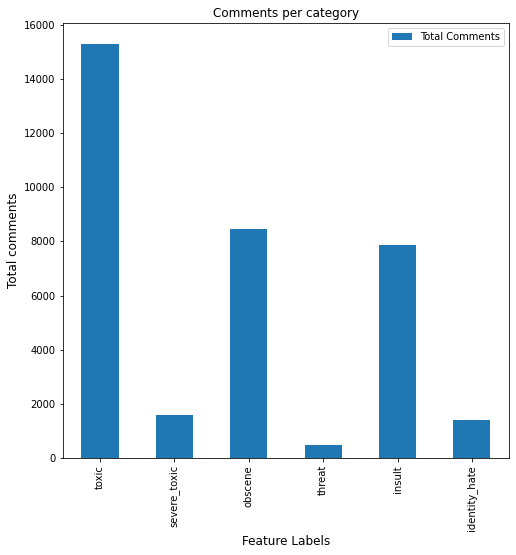

In [12]:
for i in categories:
    counts.append((i, feature[i].sum()))
    
df_1 = pd.DataFrame(counts, columns=['Feature Labels', 'Total Comments'])
df_1.plot(x='Feature Labels', y='Total Comments', kind='bar',figsize=(8,8))
plt.title("Comments per category")
plt.ylabel('Total comments', fontsize=12)
plt.xlabel('Feature Labels', fontsize=12)

In [13]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))

def to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)

def remove_whitespaces(text):
    return text.strip()

def remove_stopwords(words, stop_words):
    return [word for word in words if word not in stop_words]
def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
    return word_tokenize(text)

def clean_text( text):
    text = remove_special_chars(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

train['comment_text'] = train['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'] = test['comment_text'].apply(lambda x: clean_text(x))

In [16]:
train['comment_text'][1]

'daww match background colour im seemingly stick thank talk january utc'

In [17]:
tok = Tokenizer(num_words=1000, oov_token='null')
tok.fit_on_texts(train['comment_text'] )
# Extract binary BoW features
#a way of extracting features from text for use in modeling
x_train = tok.texts_to_sequences(train['comment_text'])
x_test = tok.texts_to_sequences(test['comment_text'])

vocab_size = len(tok.word_index) + 1
vocab_size

208756

LSTM****

In [18]:
maxlen = max([len(t) for t in x_train])
maxlen

1250

In [19]:
len(x_train[0])


26

In [20]:
len(x_train[25])


13

In [21]:
train['comment_text'][1]

'daww match background colour im seemingly stick thank talk january utc'

In [24]:
train['comment_text'][16]

'bye dont look come think comming back tosser'

In [26]:
train[['toxic' ,'severe_toxic' ,'obscene' ,'threat' ,'insult' ,'identity_hate']].sum()


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [27]:
training_padded = pad_sequences(x_train,
                                maxlen=50, 
                                truncating='post', 
                                padding='post'
                               )
test_padded = pad_sequences(x_test,
                            maxlen=50, 
                            truncating='post', 
                            padding='post'
                               )

In [30]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edit make username hardcore metall...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww match background colour im seemingly stic...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really try edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestion improvement wonder s...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,second time ask view completely contradict cov...,0,0,0,0,0,0
159567,ffea4adeee384e90,ashamed horrible thing put talk page,0,0,0,0,0,0
159568,ffee36eab5c267c9,spitzer umm there actual article prostitution ...,0,0,0,0,0,0
159569,fff125370e4aaaf3,look like actually put speedy first version de...,0,0,0,0,0,0


In [34]:
training_padded[0]


array([ 470,    4,    8,  541, 9475, 9475,  637,   71, 9475,  139, 9475,
       9475,  430,   65,  987, 9475, 9475,   10,   14,   36,  228,    6,
          3,   82,   24, 9475,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [35]:
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 128, input_length=50))
model.add(layers.LSTM(512, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.LSTM(128, dropout=0.2,recurrent_dropout=0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))



model.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy'])

model.summary()

2023-01-01 21:15:30.903545: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 128)           26720768  
_________________________________________________________________
lstm (LSTM)                  (None, 50, 512)           1312768   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 102       
Total params: 28,363,894
Trainable params: 28,363,894
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(training_padded,
                     train[['toxic' ,'severe_toxic' ,'obscene' ,'threat' ,'insult' ,'identity_hate']],
                    epochs=3,
                    batch_size=512,
                   validation_split=0.2)

2023-01-01 21:16:26.477138: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
250/250 [==============================] - 1229s 5s/step - loss: 0.1678 - accuracy: 0.8858 - val_loss: 0.1410 - val_accuracy: 0.9941
Epoch 2/3
250/250 [==============================] - 1212s 5s/step - loss: 0.1412 - accuracy: 0.9942 - val_loss: 0.1410 - val_accuracy: 0.9941
Epoch 3/3
250/250 [==============================] - 1247s 5s/step - loss: 0.1412 - accuracy: 0.9942 - val_loss: 0.1409 - val_accuracy: 0.9941


In [37]:
history_dict = history.history
history_dict.keys()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

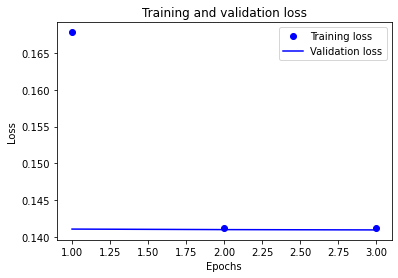

In [38]:
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

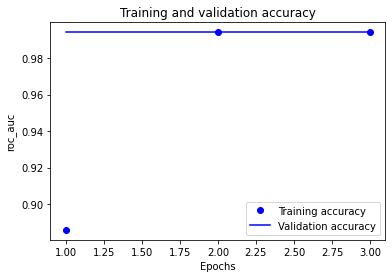

In [39]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

In [40]:
preds = model.predict(test_padded)
preds

array([[0.09079027, 0.01045388, 0.05319971, 0.00366744, 0.04827619,
        0.00910264],
       [0.09079027, 0.01045379, 0.05319971, 0.00366744, 0.04827619,
        0.00910264],
       [0.09079027, 0.01045382, 0.05319971, 0.00366741, 0.04827619,
        0.00910264],
       ...,
       [0.09079027, 0.01045382, 0.05319971, 0.00366741, 0.04827619,
        0.00910264],
       [0.09079018, 0.01045379, 0.05319959, 0.00366741, 0.04827619,
        0.00910264],
       [0.09079027, 0.01045382, 0.05319971, 0.00366741, 0.04827619,
        0.00910264]], dtype=float32)

In [41]:
test.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful youll ever whats ha...
1,0000247867823ef7,rfc title fine imo
2,00013b17ad220c46,source zawe ashton lapland —
3,00017563c3f7919a,look back source information update correct fo...
4,00017695ad8997eb,dont anonymously edit article


In [42]:
final = pd.DataFrame()
columns = ['toxic' ,'severe_toxic' ,'obscene' ,'threat' ,'insult' ,'identity_hate']
final['id'] = test['id']
final[columns] = preds

In [43]:
final.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.09079,0.010454,0.0532,0.003667,0.048276,0.009103
1,0000247867823ef7,0.09079,0.010454,0.0532,0.003667,0.048276,0.009103
2,00013b17ad220c46,0.09079,0.010454,0.0532,0.003667,0.048276,0.009103
3,00017563c3f7919a,0.09079,0.010454,0.0532,0.003667,0.048276,0.009103
4,00017695ad8997eb,0.09079,0.010454,0.0532,0.003667,0.048276,0.009103


In [44]:
model.save('tox_model.h5')
